## Data Cleaning (keeping only images with faces and more than 1 eyes)

In [98]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
%matplotlib inline

### Importing Image

In [99]:
img = cv2.imread(r"D:\VS Code\marvel_celebrity_image_classification\model\test_images\18.jpg")
img.shape

(1677, 1677, 3)

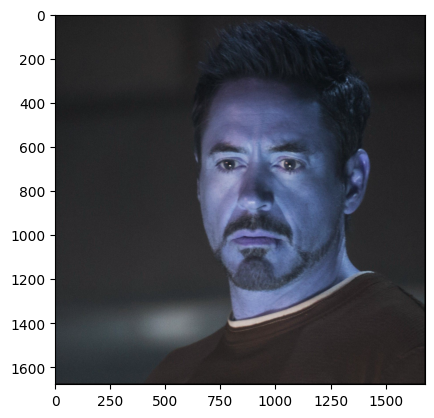

In [100]:
plt.imshow(img)

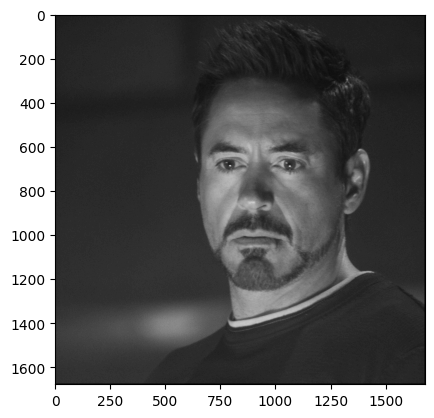

In [101]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')

### Detecting Position of Face in Images

In [22]:
face_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade= cv2.CascadeClassifier('D:\\VS Code\\marvel_celebrity_image_classification\\model\\opencv\\haarcascades\\haarcascade_eye.xml')

faces = face_cascade.detectMultiScale(gray,1.3,5)
faces

#Returned Values of faces (x,y,width & height) from where face starts forming a rectangle

array([[498, 317, 852, 852]], dtype=int32)

In [23]:
(x,y,w,h) = faces[0]
print(x,y,w,h)

498 317 852 852


### Plotting Red Rectangle around face in Image

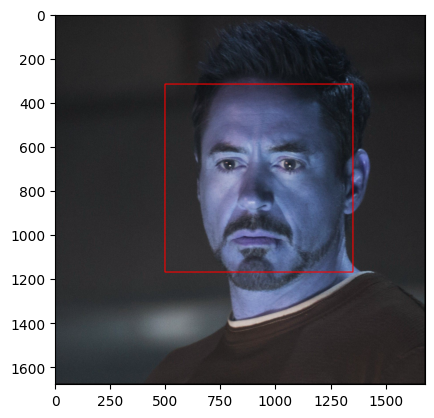

In [24]:
face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),4)
plt.imshow(face_img)

cropped_img = img[y:y+h, x:x+w]
#plt.imshow(cropped_img)

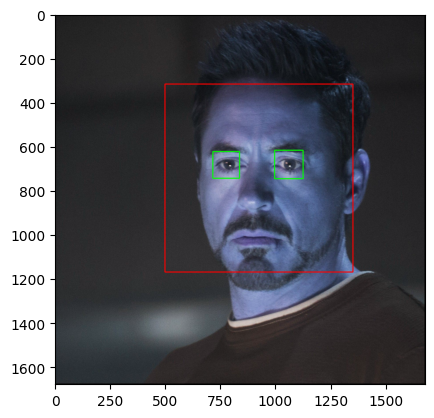

In [25]:
eyes = eye_cascade.detectMultiScale(gray,1.3,5)
for (ex,ey,ew,eh) in eyes:
    eye_img = cv2.rectangle(img,(ex,ey),(ex+ew,ey+eh),(0,255,0),3)
    
plt.imshow(eye_img)
#plt.imshow(cropped_img, cmap='gray')

### Funtion to return cropped Image

In [26]:
def crop_img(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Detect faces in the image
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    # Check if one or more faces are detected
    if len(faces) >= 1:
        x, y, w, h = faces[0]
        cropped_gray_face = gray[y:y+h, x:x+w]
        cropped_color_face = img[y:y+h, x:x+w]
        # Detect eyes within the cropped face
        eyes = eye_cascade.detectMultiScale(cropped_gray_face)
        # Check if exactly two eyes are detected
        if len(eyes) >= 2:
            return cropped_color_face      
       
#for (ex,ey,ew,eh) in eyes:
    #    eye_img = cv2.rectangle(img,(ex,ey),(ex+ew,ey+eh),(0,255,0),3)

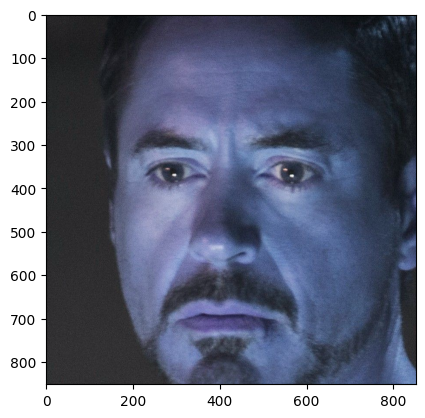

In [27]:
cropped_img = crop_img(r"D:\VS Code\marvel_celebrity_image_classification\model\test_images\18.jpg")    
plt.imshow(cropped_img)
#print(cropped_img)

### Creating directories and storing path of all datasets

In [28]:
# Storing paths in variables
path_to_data = "./Dataset/"
path_to_cr_data = "./Dataset/cropped/"

In [102]:
#Storing path of individual persons images
import os
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

img_dirs

['./Dataset/Captain_America',
 './Dataset/cropped',
 './Dataset/Spider_Man-Toby_Maguire',
 './Dataset/Thor',
 './Dataset/Tony_Stark',
 './Dataset/Wolverine']

In [30]:
# If cropped folder exists remove it and create new folder, else create new folder

import shutil
if os.path.exists(path_to_cr_data):
    shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

### Storing cropped Images in Directories

In [31]:
#Celebrity name using directories
#Storing cropped Images into new directories
cropped_img_dirs = []
celebrity_file_names_dict = {}

for img_dir in img_dirs:
    count = 1
    celebrity_name = img_dir.split('/')[-1]
    print(celebrity_name)

    celebrity_file_names_dict[celebrity_name] = []

    for entry in os.scandir(img_dir):
        cropped_color_face = crop_img(entry.path)
        if cropped_color_face is not None:
            cropped_folder = path_to_cr_data + celebrity_name
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_img_dirs.append(cropped_folder)
                print("Generating Cropped Images in folder:", cropped_folder)
            
            #Storing cropped images in its respective folder
            cropped_file_name = celebrity_name + str(count) + ".png"
            cropped_file_path = cropped_folder + "/" + cropped_file_name

            cv2.imwrite(cropped_file_path, cropped_color_face)
            #Storing name of all image file paths in dictionary
            celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
            count+=1


#After doing few Manual Cleaning Data Cleaning is Done

Captain_America
Generating Cropped Images in folder: ./Dataset/cropped/Captain_America
Spider_Man-Toby_Maguire
Generating Cropped Images in folder: ./Dataset/cropped/Spider_Man-Toby_Maguire
Thor
Generating Cropped Images in folder: ./Dataset/cropped/Thor
Tony_Stark
Generating Cropped Images in folder: ./Dataset/cropped/Tony_Stark
Wolverine
Generating Cropped Images in folder: ./Dataset/cropped/Wolverine


## Feature Engineering using Wavelet Transformation

In [103]:
#Function for Wavelet transformation for feature Exctraction
import numpy as np
import pywt
import cv2    

def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

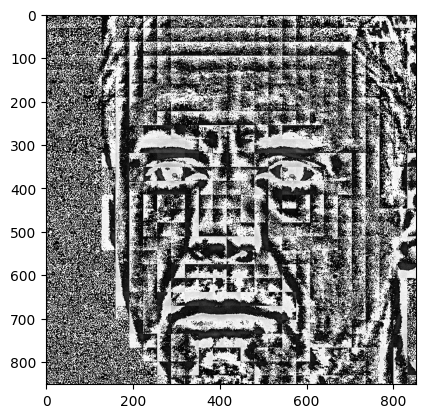

In [104]:
im_har = w2d(cropped_img,'db1',5)
plt.imshow(im_har, cmap='gray')

### Using Stacked Raw (Cropped) and Wavelet Transformed Image for Input

In [117]:
# Updating Dictionary removing paths of deleted images

celebrity_file_names_dict = {}
for img_dir in cropped_img_dirs:
    celebrity_name = img_dir.split('/')[-1]
    file_list = []
    for entry in os.scandir(img_dir):
        file_list.append(entry.path)
    celebrity_file_names_dict[celebrity_name] = file_list

celebrity_file_names_dict

{'Captain_America': ['./Dataset/cropped/Captain_America\\Captain_America1.png',
  './Dataset/cropped/Captain_America\\Captain_America10.png',
  './Dataset/cropped/Captain_America\\Captain_America11.png',
  './Dataset/cropped/Captain_America\\Captain_America13.png',
  './Dataset/cropped/Captain_America\\Captain_America14.png',
  './Dataset/cropped/Captain_America\\Captain_America15.png',
  './Dataset/cropped/Captain_America\\Captain_America16.png',
  './Dataset/cropped/Captain_America\\Captain_America17.png',
  './Dataset/cropped/Captain_America\\Captain_America18.png',
  './Dataset/cropped/Captain_America\\Captain_America19.png',
  './Dataset/cropped/Captain_America\\Captain_America2.png',
  './Dataset/cropped/Captain_America\\Captain_America20.png',
  './Dataset/cropped/Captain_America\\Captain_America21.png',
  './Dataset/cropped/Captain_America\\Captain_America23.png',
  './Dataset/cropped/Captain_America\\Captain_America24.png',
  './Dataset/cropped/Captain_America\\Captain_America

In [118]:
# Assuming celebrity_file_names_dict is a dictionary where each key has a list of values
value_counts = {key: len(values) for key, values in celebrity_file_names_dict.items()}

# Print the counts of values for each key
print(value_counts)


{'Captain_America': 26, 'Spider_Man-Toby_Maguire': 35, 'Thor': 40, 'Tony_Stark': 37, 'Wolverine': 23}


### Oversampling to Balance Data

In [119]:
import random
from collections import Counter

# Assuming 'celebrity_file_names_dict' is a dictionary where keys are class names, and values are lists of file names
max_samples = max([len(v) for v in celebrity_file_names_dict.values()])

# Oversample minority classes
balanced_data = {}
for key, value_list in celebrity_file_names_dict.items():
    if len(value_list) < max_samples:
        # Randomly sample with replacement to reach the max_samples size
        oversampled_list = random.choices(value_list, k=max_samples)
        balanced_data[key] = oversampled_list
    else:
        balanced_data[key] = value_list

# Now 'balanced_data' contains oversampled datasets with an equal number of images for each class
balanced_data

{'Captain_America': ['./Dataset/cropped/Captain_America\\Captain_America29.png',
  './Dataset/cropped/Captain_America\\Captain_America3.png',
  './Dataset/cropped/Captain_America\\Captain_America13.png',
  './Dataset/cropped/Captain_America\\Captain_America23.png',
  './Dataset/cropped/Captain_America\\Captain_America1.png',
  './Dataset/cropped/Captain_America\\Captain_America23.png',
  './Dataset/cropped/Captain_America\\Captain_America27.png',
  './Dataset/cropped/Captain_America\\Captain_America25.png',
  './Dataset/cropped/Captain_America\\Captain_America27.png',
  './Dataset/cropped/Captain_America\\Captain_America24.png',
  './Dataset/cropped/Captain_America\\Captain_America4.png',
  './Dataset/cropped/Captain_America\\Captain_America18.png',
  './Dataset/cropped/Captain_America\\Captain_America8.png',
  './Dataset/cropped/Captain_America\\Captain_America3.png',
  './Dataset/cropped/Captain_America\\Captain_America29.png',
  './Dataset/cropped/Captain_America\\Captain_America1.p

In [120]:
# Assuming celebrity_file_names_dict is a dictionary where each key has a list of values
value_counts = {key: len(values) for key, values in balanced_data.items()}

# Print the counts of values for each key
print(value_counts)

{'Captain_America': 40, 'Spider_Man-Toby_Maguire': 40, 'Thor': 40, 'Tony_Stark': 40, 'Wolverine': 40}


### Labelling(Numeric Values) Names of Celebrities 

In [121]:
class_dict = {}
count = 0

for celebrity_name in balanced_data.keys():
    class_dict[celebrity_name] = count
    count+= 1

class_dict


{'Captain_America': 0,
 'Spider_Man-Toby_Maguire': 1,
 'Thor': 2,
 'Tony_Stark': 3,
 'Wolverine': 4}

### Creating Input and Output Labels

In [122]:
#Iterating through each image using Dictionary of  celebrity Names and their path

X,y= [],[]

for celebrity_name, training_files in balanced_data.items():
    for training_image in training_files:

        img = cv2.imread(training_image)
        # Skip those files which are manually deleted and return None 
        #if img is None:
        #    continue
        scaled_raw_img = cv2.resize(img, (32,32))
        
        img_har = w2d(img, 'db1', 5)
        scaled_img_har = cv2.resize(img_har, (32,32))
        
        #Vertically Stacking (*3 is RGB color)
        combined_img = np.vstack((scaled_raw_img.reshape(32*32*3,1), scaled_img_har.reshape(32*32,1)))

        X.append(combined_img)
        y.append(class_dict[celebrity_name])


In [123]:
# 32*32*3 + 32*32 (x*y*RGB)
len(X[0])

4096

In [124]:
#Reshaping to float to avoid warnings in sklearn
X= np.array(X).reshape(len(X),4096).astype(float)
X.shape

(200, 4096)

In [125]:
X[0]

array([ 67.,  89.,  80., ...,   4.,  14., 220.])

## Training the Model

In [126]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [127]:
#Splitting training and test Data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

### Creating Pipeline

In [128]:
pipe = Pipeline([('scaler', StandardScaler()),
                 ('svc', SVC(kernel= 'rbf', C = 10))
                 ])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.84

In [129]:
len(X_test)

50

In [130]:
#Report for Precision
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      0.91      0.95        11
           1       0.90      1.00      0.95         9
           2       0.60      0.75      0.67         8
           3       0.92      0.85      0.88        13
           4       0.75      0.67      0.71         9

    accuracy                           0.84        50
   macro avg       0.83      0.83      0.83        50
weighted avg       0.85      0.84      0.84        50



### Hyperparameter tuning using Grid Search CV

In [131]:
# Creating dictionary for models and their parameters
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    },
    'KNN' :{
        'model': KNeighborsClassifier(n_neighbors=5),
        'params': {
        }
    }
}

In [132]:
#Checks all Models and their Paramters

import pandas as pd
import warnings

warnings.filterwarnings("ignore", category=FutureWarning, module='sklearn')

scores = []
best_estimators = {}

for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.820000,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.646667,{'randomforestclassifier__n_estimators': 5}
2,logistic_regression,0.826667,{'logisticregression__C': 1}
3,KNN,0.593333,{}


### Testing Model on test set with hypertuned parameters

In [133]:
trained_model = ['svm','random_forest','logistic_regression','KNN']

for model in trained_model:
    test_score = (best_estimators[model].score(X_test,y_test))
    print(f"{model}: {test_score:.2f}")  # Use f-strings to format the output nicely
    #print(model + ": " + str(round(test_score, 2)))

svm: 0.96
random_forest: 0.74
logistic_regression: 0.90
KNN: 0.40


### Creating Pipeline with Best Classifier

In [141]:
#SVM Performs best in Test Data
pipe = Pipeline([('scaler', StandardScaler()),
                 ('svc', best_estimators['svm'])
                 ])

pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.96

## Evaluating Model
### Confusion Matrix

In [142]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pipe.predict(X_test))
cm

array([[11,  0,  0,  0,  0],
       [ 0,  9,  0,  0,  0],
       [ 0,  0,  7,  0,  1],
       [ 0,  0,  0, 12,  1],
       [ 0,  0,  0,  0,  9]])

Text(70.72222222222221, 0.5, 'Truth')

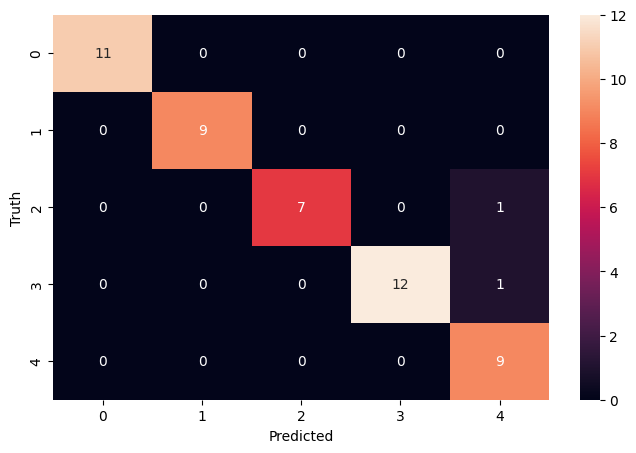

In [143]:
#Plotting Confusion Matrix
import seaborn as sn
plt.figure(figsize=(8,5))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

### Precision Report

In [144]:
print(classification_report(y_test, pipe.predict(X_test)))
#Report

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00         9
           2       1.00      0.88      0.93         8
           3       1.00      0.92      0.96        13
           4       0.82      1.00      0.90         9

    accuracy                           0.96        50
   macro avg       0.96      0.96      0.96        50
weighted avg       0.97      0.96      0.96        50



In [148]:
#Best Estimators
best_estimators['svm']

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc',
                 SVC(C=1, gamma='auto', kernel='linear', probability=True))])

## Saving Trained Model

In [149]:
import joblib

joblib.dump(pipe, 'saved_model.pkl')

['saved_model.pkl']

### Saving Class Dictionary Labels

In [150]:
import json

with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))